# Finetuning
1. Preparing data
2. Training a linear model
3. Updating VGG

We start with our usual imports:

In [1]:
%matplotlib inline

from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Saving a couple of relevant directories as variables for the sake of convenience:

In [2]:
wk_dir = os.getcwd()
data_dir = wk_dir + "/../../data/kg/cd-redux/"

model_dir = data_dir + "/models/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

On larger data sets, functions like `get_data` (which we're about to encounter in a minute) can actually take a while to run. So what we're doing here is defining a way to save the arrays we get from our functions so we won't have to run them again if we want to use them later:

In [3]:
import bcolz

def save_array(fname, arr): 
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname): 
    return bcolz.open(fname)[:]

This is just an extension I use that triggers a browser notification when the kernel is idle, so I'm not sitting around waiting for the notebook to finish:

In [4]:
%%javascript
Jupyter.notebook.config.update({"load_extensions":{"notify":true}})

<IPython.core.display.Javascript object>

## Preparing our data
### Batches & arrays

In [5]:
trn_batches = get_batches(data_dir + "/train/", shuffle=False, batch_size=1)
val_batches = get_batches(data_dir + "/valid/", shuffle=False, batch_size=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
%%time 
trn_data = get_data(data_dir + "/train/")
val_data = get_data(data_dir + "/valid/")
# Takes about 4 minutes

In [ ]:
save_array(model_dir + "trn_data.bc", trn_data)
save_array(model_dir + "val_data.bc", val_data)

*Running `get_data` on our training set then either `load_array` or `Vgg16` sometimes causes a memory error. To avoid this I've been running `save_array` on the results, restarting the kernel, then running the notebook again **without** the `get_data` and `save_array` cells, which seems to do the trick.* 

In [6]:
trn_data = load_array(model_dir + "trn_data.bc")
val_data = load_array(model_dir + "val_data.bc")

Okay, what's going on here? We have training and validation *batches*, as well as training and validation *data*. 

Neither `get_batches` nor `get_data` has a docstring, so we can try to look at the source code for each function:

```
def get_data(path, target_size=(224,224)):
    batches = get_batches(
        path, 
        shuffle=False, 
        batch_size=1, 
        class_mode=None, 
        target_size=target_size
    )
    return np.concatenate(
        [batches.next() for i in range(batches.nb_sample)]
    )
    
def get_batches(
        dirname, 
        gen=image.ImageDataGenerator(), 
        shuffle=True, 
        batch_size=4, 
        class_mode='categorical',
        target_size=(224,224)
    ):
    return gen.flow_from_directory(
        dirname, 
        target_size=target_size,
        class_mode=class_mode, 
        shuffle=shuffle, 
        batch_size=batch_size
    )
```

~~It looks like the key difference is that `get_batches` uses `image.ImageDataGenerator`. I think `get_batches` returns a collection of images and their labels, whereas `get_data` returns the image data in a numerical format. Both `get_batches` and `get_data` are acting on the same training and validation data.~~

**Correction:** `get_batches` uses `image.ImageDataGenerator` to **return a DirectoryIterator object** containing all the images in the specified folder. `get_data` uses `get_batches` under the hood, but returns those same images in the original order and **as a NumPy array**.

We can look at each data type:

In [7]:
type(trn_batches)

keras.preprocessing.image.DirectoryIterator

In [8]:
type(trn_data)

numpy.ndarray

`trn_batch` is a DirectoryIterator object (whatever that means), and `trn_data` is a NumPy array.

Trying to access the first item in `trn_data` gives us:

In [9]:
trn_data[0]

array([[[ 144.,  152.,  156., ...,   38.,   40.,   38.],
        [ 195.,  186.,  161., ...,   38.,   39.,   39.],
        [ 156.,  159.,  146., ...,   39.,   39.,   40.],
        ..., 
        [ 133.,  140.,  105., ...,   97.,  109.,  107.],
        [ 128.,  130.,   93., ...,  104.,  111.,  117.],
        [ 109.,  116.,  117., ...,  111.,  116.,  124.]],

       [[ 152.,  160.,  167., ...,   37.,   39.,   38.],
        [ 203.,  194.,  172., ...,   37.,   38.,   39.],
        [ 164.,  170.,  159., ...,   38.,   38.,   40.],
        ..., 
        [ 129.,  136.,  101., ...,   43.,   55.,   52.],
        [ 124.,  126.,   89., ...,   49.,   56.,   63.],
        [ 105.,  112.,  113., ...,   56.,   61.,   71.]],

       [[ 171.,  181.,  187., ...,   43.,   45.,   38.],
        [ 224.,  215.,  192., ...,   43.,   44.,   39.],
        [ 185.,  190.,  178., ...,   44.,   44.,   40.],
        ..., 
        [ 154.,  161.,  126., ...,    0.,   11.,   11.],
        [ 149.,  151.,  114., ...,    8., 

If we tried to access `trn_batches` in the same way, we would get an error telling us the DirectoryIterator object doesn't support indexing.

`trn_data[0]` is an image with 3 color channels (red, green, blue), and a resolution of 224 by 224 pixels:

In [10]:
trn_data[0].shape

(3, 224, 224)

`trn_data` (and `val_data`!) is just a bunch of these:

In [11]:
trn_data.shape

(23000, 3, 224, 224)

### Classes & labels

In [12]:
def onehot(x):
    return np.array(
        OneHotEncoder().fit_transform(
            x.reshape(-1, 1)
        ).todense()
    )

In [13]:
trn_classes = trn_batches.classes
trn_labels = onehot(trn_classes)

What's this? 

Well first we're getting our **classes** from `trn_batches`. Classes are assigned to each image depending on the folder they're in. Taking a look inside the training folder in our data directory, we can see that the cats folder appears before the dogs folder, so the images in our cats folder are automatically assigned a class of 0, and the images in our dogs folder get a class of 1.

If we look at the first few classes, we can see that they do have values of 0:

In [14]:
trn_classes[:5]

array([0, 0, 0, 0, 0], dtype=int32)

And the last few classes have values of 1:

In [15]:
trn_classes[-5:]

array([1, 1, 1, 1, 1], dtype=int32)

Next, we have to turn our classes into **labels**.

Most data science algorithms work best when categorical data is in a **one-hot encoded format**. We're not going to get into why, or where the name comes from (a quick Google search didn't turn anything up) but one-hot encoding works like this. Say we had three image categories in our dataset:

|image_id|image_category|
|--------|--------------|
|1       |Cat           |
|2       |Dog           |
|3       |Dog           |
|4       |Bird          |

One-hot encoding would turn each of those categories into its own column, and each row would have either a 1 or a 0 in that column depending on its original category value:

|image_id|image_category|category_cat|category_dog|category_bird|
|--------|--------------|------------|------------|-------------|
|1       |Cat           |1           |0           |0            |
|2       |Dog           |0           |1           |0            |
|3       |Dog           |0           |1           |0            |
|4       |Bird          |0           |0           |1            |

In our case, we only have two categories (cat and dog) so our one-hot encoded values look like this:

In [16]:
trn_labels[:3]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

1 in the first column means cat...

In [17]:
trn_labels[-3:]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

... And 1 in the second colummn means dog.

We can do the same for our validation data:

In [18]:
val_classes = val_batches.classes 
val_labels = onehot(val_classes)

## Training a linear model

Now that we're done transforming our batches into labels, we can actually get the VGG default model...

In [19]:
vgg = Vgg16()
model = vgg.model

In [20]:
batch_size=128

... And have it make predictions on our training and validation data. This is the data we looked at before where each image took the shape (3, 228, 228).

In [ ]:
%%time 
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)
# Takes 10-14 minutes

In [ ]:
save_array(model_dir + 'trn_features.bc', trn_features)
save_array(model_dir + 'val_features.bc', val_features)

Running `predict` can take even longer than `get_data` (and trigger the same kinds of memory issues) so we're going to save the results as well. If we run into problems, we can restart the kernel and pick it up from here:

In [21]:
trn_features = load_array(model_dir + 'trn_features.bc')
val_features = load_array(model_dir + 'val_features.bc')

In [22]:
trn_features[0][:5]

array([  7.6929e-08,   1.8921e-06,   1.4352e-06,   8.9848e-07,   1.6095e-07], dtype=float32)

What's up with these predictions? Well, VGG was trained on the ImagetNet dataset, which has 1,000 image categories. So for each image in our dataset, it returns the probability of that image belonging to each of the 1,000 categories:

In [23]:
trn_features[0].shape

(1000,)

We're not going to look at all 1,000 values here, but if we did we would expect to see values close to 0 for most the categories, with some higher values for the categories representing different species of cat in the ImageNet dataset.

In [24]:
lm = Sequential(
    [Dense(2, input_shape=(1000,), activation="softmax")]
)
lm.compile(
    optimizer=RMSprop(lr=0.1),
    loss="categorical_crossentropy"
)

We first encountered this code when we built our linear model on [Day Twelve](http://theianchan.com/one-data-science-a-day/day-twelve/). 

`Sequential` is a linear stack of layers in Keras, and `Dense` is a single layer in the stack.

The parameters we passed to `Dense` tell it to accept an input with 1,000 columns (the probabilities for each ImageNet category), and produce an output with 2 columns ([1, 0] for cat or [0, 1] for dog).

In [25]:
%%time 
lm.fit(
    trn_features,
    trn_labels,
    nb_epoch=3,
    batch_size=batch_size,
    validation_data=(
        val_features,
        val_labels
    )
)
# Takes about 2 seconds even on 3 epochs, which I did not expect

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.1056 - val_loss: 0.0874
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0743 - val_loss: 0.0938
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0702 - val_loss: 0.0979
CPU times: user 2.05 s, sys: 476 ms, total: 2.52 s
Wall time: 2.96 s


All we're doing here is fitting our newly created linear model to the features (probabilities for each ImageNet category) and labels (one-hot encoded [1, 0] for cat or [0, 1] for dog) we created for our training data, and validating it against the features and labels we created for our validation data.

To get a summary of our model we can do:

In [26]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


Which tells us we have a single Dense layer that produces an output shaped (, 2)... Which is exactly what we want.

Now that we know the model does what we want, let's make a prediction against our validation data:

In [27]:
preds = lm.predict_classes(val_features, batch_size=batch_size)

1280/2000 [==================>...........] - ETA: 0s

And check the accuracy of our predictions against our known validation classes:

[[ 947   32]
 [  18 1003]]


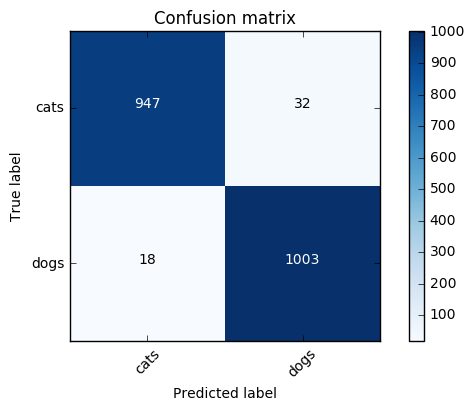

In [28]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

What we're looking at is a confusion matrix that shows our model's predictions against our validation data's actual labels. 

The left side of the matrix represents all the guesses of "cat" made by our model, and the right side represents all the guesses of "dog". The top half of the matrix represents all the actual labels of "cat" and the bottom half represents all the actual labels of "dog".

In the top left corner, our guesses of "cat" overlap with actual "cat" labels. The same thing but for "dog" in the bottom right. The top right corner are guesses of "dog" we made when the label was actually "cat". And in the bottom left we have the guesses of "cat" made when the label was actually "dog".

**Our model predicted 1,950 of the 2,000 images in our validation set correctly, so the validation accuracy of our model is 97.50%.**

## Updating VGG

Now we have a model that does a pretty good job taking VGG's outputs and making a prediction on the cats vs dogs dataset. But we still have to run VGG, take its outputs, and feed them into our new model.

What we're going to do now is modify VGG so it can do all that in a single step.

First, let's look at the layers in the VGG model:

In [29]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Wow, VGG has a **ton** of layers! This can look kind of overwhelming, but towards the bottom we should actually see a couple of things that we recognize. 

The very last layer, for example, is a Dense layer with an output shape of (, 1000). In our linear model, our Dense layer had a output shape of (, 2). We can now see the VGG layer responsible for producing the 1,000 probabilites we've been using as our inputs.

The other layers - Dropout, MaxPooling, Convolution, etc - are just different types of layers. We'll get to them another time.

If you look at the very top, there's a Lambda layer with an output shape of (, 3, 224, 224). We've seen this shape before! This is the layer responsible for taking our images (3 color channels, 244 pixels by 224 pixels) and getting this whole process started!

First, we're going to remove the last layer - the one that classifies our images into their final ImageNet categories. 

In [30]:
model.pop()

Why?

Well, as we've previously observed, ImageNet doesn't have a category for cat or dog. ImageNet *does* have 18 species of cat and 189 species of dog (which you can explore [here](http://image-net.org/explore)), which is an unnecessary level of granularity for our purposes. 

VGG makes its classifications by identifying progressively higher-level details in each image, for example:

1. The first layer might detect edges in the image
2. Another layer might detect corners, or parallel lines
3. Another layer might detect circles...
4. ... Or circles within circles, representing an eye or a wheel
5. A later layer might detect the texture or fur...
6. ... Or the relative position of elements that make up a face

If we look at the second-to-last VGG layer, each output has 4,096 values. These do *not* necessarily correspond to image features that would be recognizable to us, so we can't assume, for example, that since the last layer predict categories like "Dalmation" or "Welsh Corgi, the second-to-last layer predicts categories like "dog".

What we *are* assuming is that by this point, VGG has learned to identify features like eyes or noses or fur that are useful to us, and we don't want to have to throw all that knowledge away.

So we're going to back up one layer and say, **"Ok VGG, instead of using all that knowledge you have about eyes and noses and fur to predict whether an image contains a Dalmation or a Welsh Corgi or 998 other things, use that knowledge to predict whether an image contains a dog or a cat."**

In [31]:
for layer in model.layers:
    layer.trainable = False

Setting our model layers' `trainable` property to `False` just means, "Don't change what you already know about eyes and noses and fur and things."

In [32]:
model.add(Dense(2, activation="softmax"))
model.compile(
    optimizer=RMSprop(lr=0.1), 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

And now we're adding a layer and compiling the model exactly like we did before.

Notice the lack of the `input_shape` parameter this time - because we're adding onto an existing model instead of creating a new one, our new layer just takes the output of the previous layer as its input.

There's also a new `metrics` parameter. The docstring says this is typical, so we're not going to worry about it for now.

Our previous next step was to call `fit` but we have to make some changes first:

In [33]:
gen = image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=True)

Remember this guy? `image.ImageDataGenerator`? Returns a batch (DirectoryIterator) object that can't be indexed? We later used the batches to create our training and validation classes, which we converted to labels with one-hot encoding.

I find it helpful here to recall what our `lm.fit` looked like:

```
lm.fit(
    trn_features,
    trn_labels,
    nb_epoch=3,
    batch_size=batch_size,
    validation_data=(
        val_features,
        val_labels
    )
)
```

The inputs to our `lm.fit` function were features (1,000 ImageNet category probabilities) and labels (one-hot encoded [0, 1] or [1, 0]). 

The inputs to the `fit_model` function we're about to define will be batches. If you check the definition for `trn_batches` above, you'll see that it contains `trn_data` (the original (3, 228, 228) NumPy arrays) and `trn_labels` - all the information needed to train our model.

In [34]:
def fit_model(model, trn_batches, val_batches, nb_epoch=1):
    model.fit_generator(
        trn_batches,
        samples_per_epoch=trn_batches.N,
        
        nb_epoch=nb_epoch,
        
        validation_data=val_batches,
        nb_val_samples=val_batches.N
    )

def fit_epochs(model, trn_batches, val_batches, nb_epoch, run):
    for i in range(nb_epoch):
        fit_model(model, trn_batches, val_batches, nb_epoch=1)
        model.save_weights(model_dir + "finetune{}{}.h5".format(run, str(i)))

I'll admit I'm not 100% on why we need a new `fit_model` function, but I think it's so we can fully utilize the parallel computing abilities of the GPU by grouping our data into batches. 

We're also creating a `fit_epochs` function so we can save our weights after each iteration.

In [35]:
%%time
fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="lastlayer")
# Takes about 10 minutes per epoch

Epoch 1/1
23000/23000 [==============================] - 621s - loss: 1.2532 - acc: 0.9190 - val_loss: 0.3926 - val_acc: 0.9750
Epoch 1/1
23000/23000 [==============================] - 622s - loss: 0.6172 - acc: 0.9611 - val_loss: 0.3600 - val_acc: 0.9760
Epoch 1/1
23000/23000 [==============================] - 623s - loss: 0.4409 - acc: 0.9721 - val_loss: 0.3519 - val_acc: 0.9770
CPU times: user 35min 52s, sys: 7min 1s, total: 42min 54s
Wall time: 31min 16s


Now we can check the accuracy of our predictions - only this time using `val_data` instead of `val_features`.

Also, `val_batches.class_indices` doesn't work for some reason so we have to manually tell our confusion matrix that cat is 0 and dog is 1. I think this has something to do with us using `gen.flow` instead of `get_batches` to define `val_batches` this time:

2000/2000 [==============================] - 50s    
[[ 935   44]
 [   7 1014]]


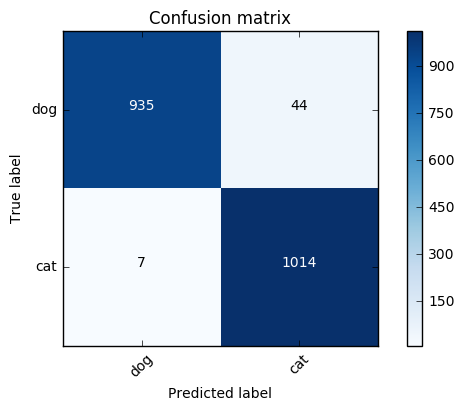

In [36]:
preds = model.predict_classes(val_data, batch_size=batch_size)
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {"cat": 0, "dog": 1})

The validation accuracy of our model is 97.38% or LOWER THAN THE VGG 1,000 + LINEAR MODEL RUBE GOLDBERG MACHINE WE CREATED EARLIER. 

This is a little bit annoying and completely unsatisfying, but I *think* it's because of the randomness that occurs when fitting models. Don't despair! Learning to modify the VGG architecture opens us up to all sorts of other possibilities... Which we'll get to next time.